#Use Hamming window with MNIST

In [ ]:
# -*- coding: utf-8 -*-
import math
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.modules.utils import _pair
from torch.nn.modules.module import Module
import numpy as np

def window_with_hamming(weight):
    N=weight.shape[-1]
    w=np.hamming(N)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting
def window_with_blackman(weight):
    N=weight.shape[-1]
    w=np.blackman(N)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting
def window_with_kaiser(weight):
    N=weight.shape[-1]
    w=np.kaiser(N,14)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting
def window_with_hanning(weight):
    N=weight.shape[-1]
    w=np.hanning(N)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d

class _ConvNd(Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups', 'bias',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dilation, transposed, output_padding,
                 groups, bias, padding_mode):
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        if transposed:
            self.weight = Parameter(torch.Tensor(
                in_channels, out_channels // groups, *kernel_size))
        else:
            self.weight = Parameter(torch.Tensor(
                out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super(_ConvNd, self).__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'
#%%
class Conv2d_window(_ConvNd):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros'):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(Conv2d_window, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias, padding_mode)

    def conv2d_forward(self, input, weight):
        weight=window_with_hamming(weight)
        if self.padding_mode == 'circular':
            expanded_padding = ((self.padding[1] + 1) // 2, self.padding[1] // 2,
                                (self.padding[0] + 1) // 2, self.padding[0] // 2)
            return F.conv2d(F.pad(input, expanded_padding, mode='circular'),
                            weight, self.bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input):
        return self.conv2d_forward(input, self.weight)


Batch_size:  64


  0%|          | 0/169001437 [00:00<?, ?it/s]

Extracting /path_to_cifar100/cifar-100-python.tar.gz to /path_to_cifar100


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /path_to_cifar100/MNIST/raw/train-images-idx3-ubyte.gz to /path_to_cifar100/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /path_to_cifar100/MNIST/raw/train-labels-idx1-ubyte.gz to /path_to_cifar100/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /path_to_cifar100/MNIST/raw/t10k-images-idx3-ubyte.gz to /path_to_cifar100/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

流式输出内容被截断，只能显示最后 5000 行内容。
2 2 2
Batch_Counter:  320
3 3 3
Batch_Counter:  340
9 9 9
Batch_Counter:  360
1 1 1
Batch_Counter:  380
0 0 0
Batch_Counter:  400
9 9 9
Batch_Counter:  420
8 8 8
Batch_Counter:  440
6 6 6
Batch_Counter:  460
2 2 2
Batch_Counter:  480
9 9 9
Batch_Counter:  500
4 4 4
Batch_Counter:  520
7 7 7
Batch_Counter:  540
8 8 8
Batch_Counter:  560
2 2 2
Batch_Counter:  580
8 8 8
Batch_Counter:  600
6 6 6
Batch_Counter:  620
5 5 5
Batch_Counter:  640
5 5 5
Batch_Counter:  660
9 9 9
Batch_Counter:  680
2 2 2
Batch_Counter:  700
4 4 4
Batch_Counter:  720
3 3 3
Batch_Counter:  740
5 5 5
Batch_Counter:  760
6 6 6
Batch_Counter:  780
5 5 5
Batch_Counter:  800
3 3 3
Batch_Counter:  820
4 4 4
Batch_Counter:  840
6 2 2
Batch_Counter:  860
1 1 1
Batch_Counter:  880
1 1 1
Batch_Counter:  900
7 7 7
Batch_Counter:  920
5 5 5
Epoch:  37
Batch_Counter:  20
5 5 5
Batch_Counter:  40
2 2 2
Batch_Counter:  60
6 6 6
Batch_Counter:  80
9 9 9
Batch_Counter:  100
0 0 0
Batch_Counter:  120
7 7 

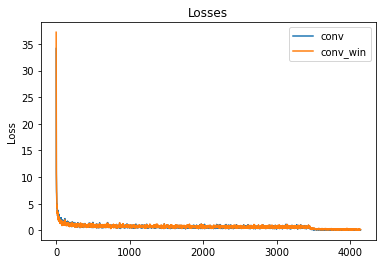

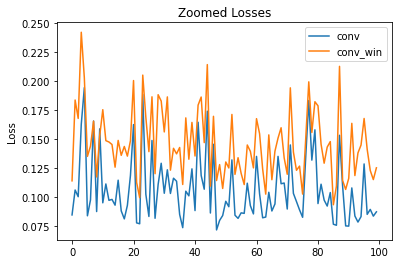

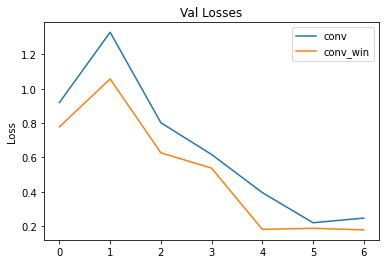

Accuracy:  [ 980. 1131. 1009. 1007.  977.  874.  945. 1022.  971. 1002.]
Accuracy_Win:  [ 980. 1132. 1019. 1005.  978.  870.  946. 1023.  973. 1001.]
class_counter:  [ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]
Accuracy_percentage:  99.18
Accuracy_win_percentage:  99.27


<Figure size 432x288 with 0 Axes>

In [ ]:
# -*- coding: utf-8 -*-

import os
import warnings


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from windowed_conv import Conv2d_window
import matplotlib.pyplot as plt
#-----------------------------------------------------------------------------------------------
"""import argparse

parser = argparse.ArgumentParser(description='CIFAR100 training with 7x7 window in all layers and weight decay')
parser.add_argument('--seed', default=None, type=int, help='rng seed')
parser.add_argument('--n_layers', default=6, type=int, help='total number of conv layers')
parser.add_argument('--save', type=str, default='/save_dir')

args = parser.parse_args()"""

# Fix seed
"""if args.seed is not None:
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    warnings.warn('You have chosen to seed training. '
                  'This will turn on the CUDNN deterministic setting, '
                  'which can slow down your training considerably! '
                  'You may see unexpected behavior when restarting '
                  'from checkpoints.')"""
#-----------------------------------------------------------------------------------------------
# Other useful definitions
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        shape=torch.prod(torch.tensor(x.shape[1:])).item()
        return x.reshape(-1,shape) # batchsize-by-rest

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

makedirs("/save_dir")

CELoss=nn.CrossEntropyLoss()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#-----------------------------------------------------------------------------------------------
# Define CIFAR100 dataloaders
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, padding=4),
                                      #transforms.Resize((14, 14)), !!!!!!!!!!!!!!!!!!!!!!!! Use this line for subsampling the size from 28x28 to 14x14 !!!!!!!!!!!!!!!!!!!!!!!!
                                      transforms.ToTensor()])
transform_test=transforms.Compose([transforms.ToTensor()])
data_path='/path_to_cifar100'
batch_size=64
print("Batch_size: ", batch_size)

# Training data
cifar100_trainset=datasets.CIFAR100(root=data_path, train=True, transform=transform_train, download=True)
MNIST_trainset = datasets.MNIST(root=data_path, train=True, transform=transform_train, download=True)
#train_dl=torch.utils.data.DataLoader(cifar100_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
train_dl=torch.utils.data.DataLoader(MNIST_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Validation data
cifar100_testset=datasets.CIFAR100(root=data_path, train=False, transform=transform_test, download=True)
MNIST_testset=datasets.MNIST(root=data_path, train=False, transform=transform_test, download=True)
#test_dl=torch.utils.data.DataLoader(cifar100_testset, batch_size=batch_size, shuffle=False, num_workers=2)
test_dl=torch.utils.data.DataLoader(MNIST_testset, batch_size=batch_size, shuffle=False, num_workers=2)
#-----------------------------------------------------------------------------------------------
# Define the 2 models
#n_inp_ch=3 # CIFAR100
n_inp_ch=1 # MNIST
n_out_ch=128
n_out2_ch=256
#n_classes=100 # CIFAR100
n_classes=10 # MNIST

# Define networks
n_layers=6

block=[]
block.append(torch.nn.Conv2d(n_inp_ch,n_out_ch,kernel_size=(7,7),stride=2,padding=(3,3),bias=False))
block.append(torch.nn.BatchNorm2d(n_out_ch))
block.append(torch.nn.ReLU())
block.append(torch.nn.Conv2d(n_out_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
block.append(torch.nn.BatchNorm2d(n_out2_ch))
block.append(torch.nn.ReLU())

block_win=[]
block_win.append(Conv2d_window(n_inp_ch,n_out_ch,kernel_size=(7,7),stride=2,padding=(3,3),bias=False))
block_win.append(torch.nn.BatchNorm2d(n_out_ch))
block_win.append(torch.nn.ReLU())
block_win.append(Conv2d_window(n_out_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
block_win.append(torch.nn.BatchNorm2d(n_out2_ch))
block_win.append(torch.nn.ReLU())

if n_layers>2:
    for i in range(n_layers-2):
        block.append(torch.nn.Conv2d(n_out2_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
        block.append(torch.nn.BatchNorm2d(n_out2_ch))
        block.append(torch.nn.ReLU())

        block_win.append(Conv2d_window(n_out2_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
        block_win.append(torch.nn.BatchNorm2d(n_out2_ch))
        block_win.append(torch.nn.ReLU())

model=torch.nn.Sequential(*block,torch.nn.AdaptiveAvgPool2d((1,1)),\
               Flatten(),torch.nn.Linear(n_out2_ch,n_classes)).to(device)

model_win=torch.nn.Sequential(*block_win,torch.nn.AdaptiveAvgPool2d((1,1)),\
               Flatten(),torch.nn.Linear(n_out2_ch,n_classes)).to(device)

if n_layers>13:
    warnings.warn("Networks deeper than 13 layers may not be ideal for small image sizes "+\
             +"(e.g. 32 x 32) and with the current width/pooling specifications")
#-----------------------------------------------------------------------------------------------
# Define optimizer
optim=torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9, weight_decay=0.001)
optim_win=torch.optim.SGD(model_win.parameters(),lr=0.01,momentum=0.9, weight_decay=0.001)
#-----------------------------------------------------------------------------------------------
# Training
loss_counter=0
log_loss=20 # track loss every 20 batches
n_epoch=90
#n_train_img=len(CIFAR10_trainset)
n_train_img=len(MNIST_trainset)

plot_loss=np.zeros(n_epoch*int(np.floor(np.ceil(n_train_img/batch_size)/log_loss)))
plot_loss_win=np.zeros(n_epoch*int(np.floor(np.ceil(n_train_img/batch_size)/log_loss)))

print("Totle number of Epochs:", n_epoch)

for i_epoch in range(n_epoch):
    print("Epoch: ", i_epoch)
    batch_counter=0
    running_loss=0
    running_loss_win=0

    # Learning rate decay
    if i_epoch==75 or i_epoch==120:
        for param_group in optim.param_groups:
            param_group['lr']=0.1*param_group['lr']
        for param_group in optim_win.param_groups:
            param_group['lr']=0.1*param_group['lr']

    for X,y in train_dl:
        batch_counter+=1
        # Train
        X=X.to(device)
        y=y.to(device)

        # Backprop model 1
        optim.zero_grad()
        pred=model(X)
        loss=CELoss(pred,y)
        loss.backward()
        optim.step()

        # Backprop model 2
        optim_win.zero_grad()
        pred_win=model_win(X)
        loss_win=CELoss(pred_win,y)
        loss_win.backward()
        optim_win.step()

        running_loss+=loss.item()
        running_loss_win+=loss_win.item()

        if batch_counter%log_loss==0:
            # print things
            print("Batch_Counter: ", batch_counter)
            print(np.argmax(pred[0,:].detach().cpu().numpy()),\
                  np.argmax(pred_win[0,:].detach().cpu().numpy()),\
                  y[0].detach().cpu().numpy())

            # update loss trace
            plot_loss[loss_counter]=running_loss
            plot_loss_win[loss_counter]=running_loss_win
            loss_counter+=1

            running_loss=0
            running_loss_win=0

# Plot losses
plt.figure(1)
plt.plot(plot_loss,label='conv')
plt.plot(plot_loss_win,label='conv_win')
plt.title('Losses')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join("/save_dir", 'loss_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')

# Plot losses zoomed in
plt.figure(2)
plt.plot(plot_loss[-100:],label='conv')
plt.plot(plot_loss_win[-100:],label='conv_win')
plt.title('Zoomed Losses')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join("/save_dir", 'loss_zoom_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')
#-----------------------------------------------------------------------------------------------
# Validation
accuracy=np.zeros(n_classes)
accuracy_win=np.zeros(n_classes)
class_counter=np.zeros(n_classes)

loss_counter=0
log_loss=20 # track loss every 20 batches
#n_test_img=len(cifar100_testset)
n_test_img=len(MNIST_testset)

plot_val_loss=np.zeros(int(np.floor(np.ceil(n_test_img/batch_size)/log_loss)))
plot_val_loss_win=np.zeros(int(np.floor(np.ceil(n_test_img/batch_size)/log_loss)))

print('Validating...')

batch_counter=0
running_loss=0
running_loss_win=0

with torch.no_grad():
    model.eval()
    model_win.eval()

    for X,y in test_dl:
        # Test
        batch_counter+=1
        X=X.to(device)

        pred=model(X)
        pred_win=model_win(X)

        loss=CELoss(pred,y.to(device))
        loss_win=CELoss(pred_win,y.to(device))
        running_loss+=loss.item()
        running_loss_win+=loss_win.item()

        # Get accuracy
        for j in range(int(y.shape[0])):
            i_class=y[j].detach().numpy().item()

            class_counter[i_class]+=1
            accuracy[i_class]+=(i_class==np.argmax(pred[j,:].detach().cpu().numpy()))
            accuracy_win[i_class]+=(i_class==np.argmax(pred_win[j,:].detach().cpu().numpy()))

        if batch_counter%log_loss==0:
            # print things
            print("Batch_Counter: ", batch_counter)

            # update loss trace
            plot_val_loss[loss_counter]=running_loss
            plot_val_loss_win[loss_counter]=running_loss_win
            loss_counter+=1

            running_loss=0
            running_loss_win=0

# Plot val loss
plt.figure(3)
plt.plot(plot_val_loss,label='conv')
plt.plot(plot_val_loss_win,label='conv_win')
plt.title('Val Losses')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig(os.path.join("/save_dir", 'val_loss_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')

# Print accuracies
print("Accuracy: ", accuracy)
print("Accuracy_Win: ", accuracy_win)
print("class_counter: ", class_counter)
print("Accuracy_percentage: ", accuracy.sum()/class_counter.sum()*100)
print("Accuracy_win_percentage: ", accuracy_win.sum()/class_counter.sum()*100)

# Save model + losses
torch.save({'state_dict': model.state_dict(), 'state_dict_win': model_win.state_dict(), 'training_loss': plot_loss, 'training_loss_win': plot_loss_win, 'val_loss': plot_val_loss, 'val_loss_win': plot_val_loss_win, 'accuracy': accuracy, 'accuracy_win': accuracy_win, 'class_counter': class_counter}, os.path.join("/save_dir", 'model_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pth'))


流式输出内容被截断，只能显示最后 5000 行内容。
9 9 9
Batch_Counter:  320
5 5 5
Batch_Counter:  340
0 0 0
Batch_Counter:  360
5 5 5
Batch_Counter:  380
4 4 4
Batch_Counter:  400
6 6 6
Batch_Counter:  420
5 5 5
Batch_Counter:  440
3 3 3
Batch_Counter:  460
1 1 1
Batch_Counter:  480
0 0 0
Batch_Counter:  500
6 6 6
Batch_Counter:  520
1 1 1
Batch_Counter:  540
5 5 5
Batch_Counter:  560
2 2 2
Batch_Counter:  580
0 0 0
Batch_Counter:  600
3 3 3
Batch_Counter:  620
7 7 7
Batch_Counter:  640
7 7 7
Batch_Counter:  660
7 7 7
Batch_Counter:  680
7 7 7
Batch_Counter:  700
0 0 0
Batch_Counter:  720
7 7 7
Batch_Counter:  740
9 9 9
Batch_Counter:  760
5 5 5
Batch_Counter:  780
8 8 8
Batch_Counter:  800
7 7 7
Batch_Counter:  820
7 7 7
Batch_Counter:  840
9 9 4
Batch_Counter:  860
8 8 8
Batch_Counter:  880
0 0 0
Batch_Counter:  900
6 6 6
Batch_Counter:  920
7 7 7
Epoch:  37
Batch_Counter:  20
1 1 1
Batch_Counter:  40
5 5 5
Batch_Counter:  60
8 8 8
Batch_Counter:  80
4 4 4
Batch_Counter:  100
9 9 9
Batch_Counter:  120
7 7 

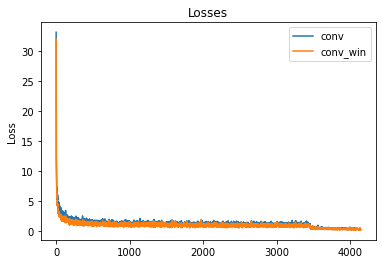

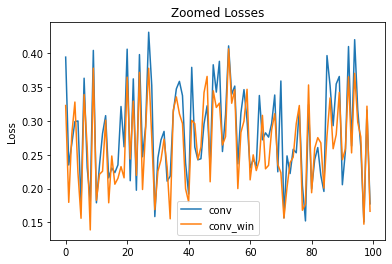

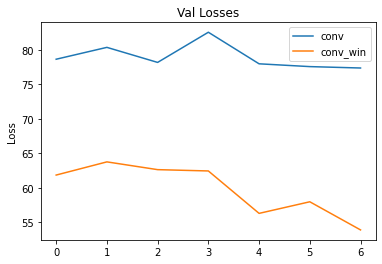

Accuracy:  [  1. 893. 149.   0.  64.   0. 115. 940.   0.   0.]
Accuracy_Win:  [  16. 1128.   72.    5.    0.   31.   13.  655.    4.    0.]
class_counter:  [ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]
Accuracy_percentage:  21.62
Accuracy_win_percentage:  19.24


<Figure size 432x288 with 0 Axes>

In [ ]:
# -*- coding: utf-8 -*-

import os
import warnings


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from windowed_conv import Conv2d_window
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize
#-----------------------------------------------------------------------------------------------
"""import argparse

parser = argparse.ArgumentParser(description='CIFAR100 training with 7x7 window in all layers and weight decay')
parser.add_argument('--seed', default=None, type=int, help='rng seed')
parser.add_argument('--n_layers', default=6, type=int, help='total number of conv layers')
parser.add_argument('--save', type=str, default='/save_dir')

args = parser.parse_args()"""

# Fix seed
"""if args.seed is not None:
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    warnings.warn('You have chosen to seed training. '
                  'This will turn on the CUDNN deterministic setting, '
                  'which can slow down your training considerably! '
                  'You may see unexpected behavior when restarting '
                  'from checkpoints.')"""
#-----------------------------------------------------------------------------------------------
# Other useful definitions
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        shape=torch.prod(torch.tensor(x.shape[1:])).item()
        return x.reshape(-1,shape) # batchsize-by-rest

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

makedirs("/save_dir")

CELoss=nn.CrossEntropyLoss()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#-----------------------------------------------------------------------------------------------
# Define CIFAR100 dataloaders
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.Resize((14, 14)),
                                      transforms.ToTensor()])
transform_test=transforms.Compose([transforms.ToTensor()])
data_path='/path_to_cifar100'
batch_size=64
print("Batch_size: ", batch_size)

# Training data
#cifar100_trainset=datasets.CIFAR100(root=data_path, train=True, transform=transform_train, download=True)
MNIST_trainset = datasets.MNIST(root=data_path, train=True, transform=transform_train, download=True)
#train_dl=torch.utils.data.DataLoader(cifar100_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
train_dl=torch.utils.data.DataLoader(MNIST_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Validation data
#cifar100_testset=datasets.CIFAR100(root=data_path, train=False, transform=transform_test, download=True)
MNIST_testset=datasets.MNIST(root=data_path, train=False, transform=transform_test, download=True)
#test_dl=torch.utils.data.DataLoader(cifar100_testset, batch_size=batch_size, shuffle=False, num_workers=2)
test_dl=torch.utils.data.DataLoader(MNIST_testset, batch_size=batch_size, shuffle=False, num_workers=2)
#-----------------------------------------------------------------------------------------------
# Define the 2 models
#n_inp_ch=3 # CIFAR100
n_inp_ch=1 # MNIST
n_out_ch=128
n_out2_ch=256
n_classes=100 # CIFAR100
n_classes=10 # MNIST

# Define networks
n_layers=6

block=[]
block.append(torch.nn.Conv2d(n_inp_ch,n_out_ch,kernel_size=(7,7),stride=2,padding=(3,3),bias=False))
block.append(torch.nn.BatchNorm2d(n_out_ch))
block.append(torch.nn.ReLU())
block.append(torch.nn.Conv2d(n_out_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
block.append(torch.nn.BatchNorm2d(n_out2_ch))
block.append(torch.nn.ReLU())

block_win=[]
block_win.append(Conv2d_window(n_inp_ch,n_out_ch,kernel_size=(7,7),stride=2,padding=(3,3),bias=False))
block_win.append(torch.nn.BatchNorm2d(n_out_ch))
block_win.append(torch.nn.ReLU())
block_win.append(Conv2d_window(n_out_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
block_win.append(torch.nn.BatchNorm2d(n_out2_ch))
block_win.append(torch.nn.ReLU())

if n_layers>2:
    for i in range(n_layers-2):
        block.append(torch.nn.Conv2d(n_out2_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
        block.append(torch.nn.BatchNorm2d(n_out2_ch))
        block.append(torch.nn.ReLU())

        block_win.append(Conv2d_window(n_out2_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
        block_win.append(torch.nn.BatchNorm2d(n_out2_ch))
        block_win.append(torch.nn.ReLU())

model=torch.nn.Sequential(*block,torch.nn.AdaptiveAvgPool2d((1,1)),\
               Flatten(),torch.nn.Linear(n_out2_ch,n_classes)).to(device)

model_win=torch.nn.Sequential(*block_win,torch.nn.AdaptiveAvgPool2d((1,1)),\
               Flatten(),torch.nn.Linear(n_out2_ch,n_classes)).to(device)

if n_layers>13:
    warnings.warn("Networks deeper than 13 layers may not be ideal for small image sizes "+\
             +"(e.g. 32 x 32) and with the current width/pooling specifications")
#-----------------------------------------------------------------------------------------------
# Define optimizer
optim=torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9, weight_decay=0.001)
optim_win=torch.optim.SGD(model_win.parameters(),lr=0.01,momentum=0.9, weight_decay=0.001)
#-----------------------------------------------------------------------------------------------
# Training
loss_counter=0
log_loss=20 # track loss every 20 batches
n_epoch=90
#n_train_img=len(CIFAR10_trainset)
n_train_img=len(MNIST_trainset)

plot_loss=np.zeros(n_epoch*int(np.floor(np.ceil(n_train_img/batch_size)/log_loss)))
plot_loss_win=np.zeros(n_epoch*int(np.floor(np.ceil(n_train_img/batch_size)/log_loss)))

print("Totle number of Epochs:", n_epoch)

for i_epoch in range(n_epoch):
    print("Epoch: ", i_epoch)
    batch_counter=0
    running_loss=0
    running_loss_win=0

    # Learning rate decay
    if i_epoch==75 or i_epoch==120:
        for param_group in optim.param_groups:
            param_group['lr']=0.1*param_group['lr']
        for param_group in optim_win.param_groups:
            param_group['lr']=0.1*param_group['lr']

    for X,y in train_dl:
        batch_counter+=1
        # Train
        #print(X.shape)
        X=X.to(device)
        y=y.to(device)

        # Backprop model 1
        optim.zero_grad()
        pred=model(X)
        loss=CELoss(pred,y)
        loss.backward()
        optim.step()

        # Backprop model 2
        optim_win.zero_grad()
        pred_win=model_win(X)
        loss_win=CELoss(pred_win,y)
        loss_win.backward()
        optim_win.step()

        running_loss+=loss.item()
        running_loss_win+=loss_win.item()

        if batch_counter%log_loss==0:
            # print things
            print("Batch_Counter: ", batch_counter)
            print(np.argmax(pred[0,:].detach().cpu().numpy()),\
                  np.argmax(pred_win[0,:].detach().cpu().numpy()),\
                  y[0].detach().cpu().numpy())

            # update loss trace
            plot_loss[loss_counter]=running_loss
            plot_loss_win[loss_counter]=running_loss_win
            loss_counter+=1

            running_loss=0
            running_loss_win=0

# Plot losses
plt.figure(1)
plt.plot(plot_loss,label='conv')
plt.plot(plot_loss_win,label='conv_win')
plt.title('Losses')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join("/save_dir", 'loss_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')

# Plot losses zoomed in
plt.figure(2)
plt.plot(plot_loss[-100:],label='conv')
plt.plot(plot_loss_win[-100:],label='conv_win')
plt.title('Zoomed Losses')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join("/save_dir", 'loss_zoom_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')
#-----------------------------------------------------------------------------------------------
# Validation
accuracy=np.zeros(n_classes)
accuracy_win=np.zeros(n_classes)
class_counter=np.zeros(n_classes)

loss_counter=0
log_loss=20 # track loss every 20 batches
#n_test_img=len(cifar100_testset)
n_test_img=len(MNIST_testset)

plot_val_loss=np.zeros(int(np.floor(np.ceil(n_test_img/batch_size)/log_loss)))
plot_val_loss_win=np.zeros(int(np.floor(np.ceil(n_test_img/batch_size)/log_loss)))

print('Validating...')

batch_counter=0
running_loss=0
running_loss_win=0

with torch.no_grad():
    model.eval()
    model_win.eval()

    for X,y in test_dl:
        # Test
        batch_counter+=1
        X=X.to(device)

        pred=model(X)
        pred_win=model_win(X)

        loss=CELoss(pred,y.to(device))
        loss_win=CELoss(pred_win,y.to(device))
        running_loss+=loss.item()
        running_loss_win+=loss_win.item()

        # Get accuracy
        for j in range(int(y.shape[0])):
            i_class=y[j].detach().numpy().item()

            class_counter[i_class]+=1
            accuracy[i_class]+=(i_class==np.argmax(pred[j,:].detach().cpu().numpy()))
            accuracy_win[i_class]+=(i_class==np.argmax(pred_win[j,:].detach().cpu().numpy()))

        if batch_counter%log_loss==0:
            # print things
            print("Batch_Counter: ", batch_counter)

            # update loss trace
            plot_val_loss[loss_counter]=running_loss
            plot_val_loss_win[loss_counter]=running_loss_win
            loss_counter+=1

            running_loss=0
            running_loss_win=0

# Plot val loss
plt.figure(3)
plt.plot(plot_val_loss,label='conv')
plt.plot(plot_val_loss_win,label='conv_win')
plt.title('Val Losses')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig(os.path.join("/save_dir", 'val_loss_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')

# Print accuracies
print("Accuracy: ", accuracy)
print("Accuracy_Win: ", accuracy_win)
print("class_counter: ", class_counter)
print("Accuracy_percentage: ", accuracy.sum()/class_counter.sum()*100)
print("Accuracy_win_percentage: ", accuracy_win.sum()/class_counter.sum()*100)

# Save model + losses
torch.save({'state_dict': model.state_dict(), 'state_dict_win': model_win.state_dict(), 'training_loss': plot_loss, 'training_loss_win': plot_loss_win, 'val_loss': plot_val_loss, 'val_loss_win': plot_val_loss_win, 'accuracy': accuracy, 'accuracy_win': accuracy_win, 'class_counter': class_counter}, os.path.join("/save_dir", 'model_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pth'))


# Use Hanning Window with MNIST

In [ ]:
# -*- coding: utf-8 -*-
import math
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.modules.utils import _pair
from torch.nn.modules.module import Module
import numpy as np

def window_with_hamming(weight):
    N=weight.shape[-1]
    w=np.hamming(N)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting
def window_with_blackman(weight):
    N=weight.shape[-1]
    w=np.blackman(N)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting
def window_with_kaiser(weight):
    N=weight.shape[-1]
    w=np.kaiser(N,14)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting
def window_with_hanning(weight):
    N=weight.shape[-1]
    w=np.hanning(N)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting

class _ConvNd(Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups', 'bias',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dilation, transposed, output_padding,
                 groups, bias, padding_mode):
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        if transposed:
            self.weight = Parameter(torch.Tensor(
                in_channels, out_channels // groups, *kernel_size))
        else:
            self.weight = Parameter(torch.Tensor(
                out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super(_ConvNd, self).__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'
#%%
class Conv2d_window(_ConvNd):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros'):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(Conv2d_window, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias, padding_mode)

    def conv2d_forward(self, input, weight):
        weight=window_with_hanning(weight)
        if self.padding_mode == 'circular':
            expanded_padding = ((self.padding[1] + 1) // 2, self.padding[1] // 2,
                                (self.padding[0] + 1) // 2, self.padding[0] // 2)
            return F.conv2d(F.pad(input, expanded_padding, mode='circular'),
                            weight, self.bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input):
        return self.conv2d_forward(input, self.weight)


流式输出内容被截断，只能显示最后 5000 行内容。
4 4 4
Batch_Counter:  320
6 6 6
Batch_Counter:  340
4 4 4
Batch_Counter:  360
2 2 2
Batch_Counter:  380
2 2 2
Batch_Counter:  400
3 3 3
Batch_Counter:  420
2 2 2
Batch_Counter:  440
0 0 0
Batch_Counter:  460
9 9 9
Batch_Counter:  480
3 3 3
Batch_Counter:  500
1 1 1
Batch_Counter:  520
2 2 2
Batch_Counter:  540
8 8 8
Batch_Counter:  560
6 6 6
Batch_Counter:  580
0 0 0
Batch_Counter:  600
4 4 4
Batch_Counter:  620
6 6 6
Batch_Counter:  640
7 7 7
Batch_Counter:  660
4 4 4
Batch_Counter:  680
6 6 2
Batch_Counter:  700
6 6 6
Batch_Counter:  720
7 7 7
Batch_Counter:  740
5 5 5
Batch_Counter:  760
3 3 3
Batch_Counter:  780
7 7 7
Batch_Counter:  800
2 2 2
Batch_Counter:  820
8 8 8
Batch_Counter:  840
0 0 0
Batch_Counter:  860
3 3 3
Batch_Counter:  880
5 5 5
Batch_Counter:  900
6 6 6
Batch_Counter:  920
8 8 8
Epoch:  37
Batch_Counter:  20
2 2 2
Batch_Counter:  40
2 2 2
Batch_Counter:  60
2 2 2
Batch_Counter:  80
6 6 6
Batch_Counter:  100
1 1 1
Batch_Counter:  120
2 2 

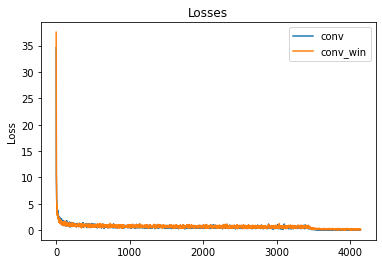

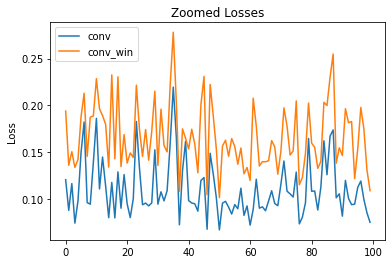

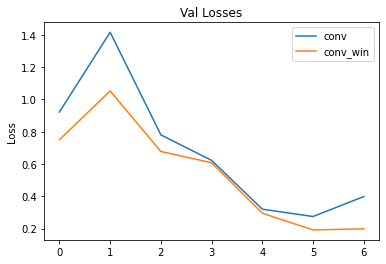

Accuracy:  [ 979. 1132. 1020. 1006.  978.  871.  944. 1020.  970. 1002.]
Accuracy_Win:  [ 979. 1131. 1022. 1005.  978.  870.  946. 1023.  972. 1001.]
class_counter:  [ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]
Accuracy_percentage:  99.22
Accuracy_win_percentage:  99.27


<Figure size 432x288 with 0 Axes>

In [ ]:
# -*- coding: utf-8 -*-

import os
import warnings


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
#from windowed_conv import Conv2d_window
import matplotlib.pyplot as plt
#-----------------------------------------------------------------------------------------------
"""import argparse

parser = argparse.ArgumentParser(description='CIFAR100 training with 7x7 window in all layers and weight decay')
parser.add_argument('--seed', default=None, type=int, help='rng seed')
parser.add_argument('--n_layers', default=6, type=int, help='total number of conv layers')
parser.add_argument('--save', type=str, default='/save_dir')

args = parser.parse_args()"""

# Fix seed
"""if args.seed is not None:
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    warnings.warn('You have chosen to seed training. '
                  'This will turn on the CUDNN deterministic setting, '
                  'which can slow down your training considerably! '
                  'You may see unexpected behavior when restarting '
                  'from checkpoints.')"""
#-----------------------------------------------------------------------------------------------
# Other useful definitions
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        shape=torch.prod(torch.tensor(x.shape[1:])).item()
        return x.reshape(-1,shape) # batchsize-by-rest

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

makedirs("/save_dir")

CELoss=nn.CrossEntropyLoss()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#-----------------------------------------------------------------------------------------------
# Define CIFAR100 dataloaders
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.ToTensor()])
transform_test=transforms.Compose([transforms.ToTensor()])
data_path='/path_to_cifar100'
batch_size=64
print("Batch_size: ", batch_size)

# Training data
cifar100_trainset=datasets.CIFAR100(root=data_path, train=True, transform=transform_train, download=True)
MNIST_trainset = datasets.MNIST(root=data_path, train=True, transform=transform_train, download=True)
#train_dl=torch.utils.data.DataLoader(cifar100_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
train_dl=torch.utils.data.DataLoader(MNIST_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Validation data
cifar100_testset=datasets.CIFAR100(root=data_path, train=False, transform=transform_test, download=True)
MNIST_testset=datasets.MNIST(root=data_path, train=False, transform=transform_test, download=True)
#test_dl=torch.utils.data.DataLoader(cifar100_testset, batch_size=batch_size, shuffle=False, num_workers=2)
test_dl=torch.utils.data.DataLoader(MNIST_testset, batch_size=batch_size, shuffle=False, num_workers=2)
#-----------------------------------------------------------------------------------------------
# Define the 2 models
#n_inp_ch=3 # CIFAR100
n_inp_ch=1 # MNIST
n_out_ch=128
n_out2_ch=256
n_classes=100 # CIFAR100
n_classes=10 # MNIST

# Define networks
n_layers=6

block=[]
block.append(torch.nn.Conv2d(n_inp_ch,n_out_ch,kernel_size=(7,7),stride=2,padding=(3,3),bias=False))
block.append(torch.nn.BatchNorm2d(n_out_ch))
block.append(torch.nn.ReLU())
block.append(torch.nn.Conv2d(n_out_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
block.append(torch.nn.BatchNorm2d(n_out2_ch))
block.append(torch.nn.ReLU())

block_win=[]
block_win.append(Conv2d_window(n_inp_ch,n_out_ch,kernel_size=(7,7),stride=2,padding=(3,3),bias=False))
block_win.append(torch.nn.BatchNorm2d(n_out_ch))
block_win.append(torch.nn.ReLU())
block_win.append(Conv2d_window(n_out_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
block_win.append(torch.nn.BatchNorm2d(n_out2_ch))
block_win.append(torch.nn.ReLU())

if n_layers>2:
    for i in range(n_layers-2):
        block.append(torch.nn.Conv2d(n_out2_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
        block.append(torch.nn.BatchNorm2d(n_out2_ch))
        block.append(torch.nn.ReLU())

        block_win.append(Conv2d_window(n_out2_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
        block_win.append(torch.nn.BatchNorm2d(n_out2_ch))
        block_win.append(torch.nn.ReLU())

model=torch.nn.Sequential(*block,torch.nn.AdaptiveAvgPool2d((1,1)),\
               Flatten(),torch.nn.Linear(n_out2_ch,n_classes)).to(device)

model_win=torch.nn.Sequential(*block_win,torch.nn.AdaptiveAvgPool2d((1,1)),\
               Flatten(),torch.nn.Linear(n_out2_ch,n_classes)).to(device)

if n_layers>13:
    warnings.warn("Networks deeper than 13 layers may not be ideal for small image sizes "+\
             +"(e.g. 32 x 32) and with the current width/pooling specifications")
#-----------------------------------------------------------------------------------------------
# Define optimizer
optim=torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9, weight_decay=0.001)
optim_win=torch.optim.SGD(model_win.parameters(),lr=0.01,momentum=0.9, weight_decay=0.001)
#-----------------------------------------------------------------------------------------------
# Training
loss_counter=0
log_loss=20 # track loss every 20 batches
n_epoch=90
#n_train_img=len(CIFAR10_trainset)
n_train_img=len(MNIST_trainset)

plot_loss=np.zeros(n_epoch*int(np.floor(np.ceil(n_train_img/batch_size)/log_loss)))
plot_loss_win=np.zeros(n_epoch*int(np.floor(np.ceil(n_train_img/batch_size)/log_loss)))

print("Totle number of Epochs:", n_epoch)

for i_epoch in range(n_epoch):
    print("Epoch: ", i_epoch)
    batch_counter=0
    running_loss=0
    running_loss_win=0

    # Learning rate decay
    if i_epoch==75 or i_epoch==120:
        for param_group in optim.param_groups:
            param_group['lr']=0.1*param_group['lr']
        for param_group in optim_win.param_groups:
            param_group['lr']=0.1*param_group['lr']

    for X,y in train_dl:
        batch_counter+=1
        # Train
        X=X.to(device)
        y=y.to(device)

        # Backprop model 1
        optim.zero_grad()
        pred=model(X)
        loss=CELoss(pred,y)
        loss.backward()
        optim.step()

        # Backprop model 2
        optim_win.zero_grad()
        pred_win=model_win(X)
        loss_win=CELoss(pred_win,y)
        loss_win.backward()
        optim_win.step()

        running_loss+=loss.item()
        running_loss_win+=loss_win.item()

        if batch_counter%log_loss==0:
            # print things
            print("Batch_Counter: ", batch_counter)
            print(np.argmax(pred[0,:].detach().cpu().numpy()),\
                  np.argmax(pred_win[0,:].detach().cpu().numpy()),\
                  y[0].detach().cpu().numpy())

            # update loss trace
            plot_loss[loss_counter]=running_loss
            plot_loss_win[loss_counter]=running_loss_win
            loss_counter+=1

            running_loss=0
            running_loss_win=0

# Plot losses
plt.figure(1)
plt.plot(plot_loss,label='conv')
plt.plot(plot_loss_win,label='conv_win')
plt.title('Losses')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join("/save_dir", 'loss_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')

# Plot losses zoomed in
plt.figure(2)
plt.plot(plot_loss[-100:],label='conv')
plt.plot(plot_loss_win[-100:],label='conv_win')
plt.title('Zoomed Losses')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join("/save_dir", 'loss_zoom_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')
#-----------------------------------------------------------------------------------------------
# Validation
accuracy=np.zeros(n_classes)
accuracy_win=np.zeros(n_classes)
class_counter=np.zeros(n_classes)

loss_counter=0
log_loss=20 # track loss every 20 batches
#n_test_img=len(cifar100_testset)
n_test_img=len(MNIST_testset)

plot_val_loss=np.zeros(int(np.floor(np.ceil(n_test_img/batch_size)/log_loss)))
plot_val_loss_win=np.zeros(int(np.floor(np.ceil(n_test_img/batch_size)/log_loss)))

print('Validating...')

batch_counter=0
running_loss=0
running_loss_win=0

with torch.no_grad():
    model.eval()
    model_win.eval()

    for X,y in test_dl:
        # Test
        batch_counter+=1
        X=X.to(device)

        pred=model(X)
        pred_win=model_win(X)

        loss=CELoss(pred,y.to(device))
        loss_win=CELoss(pred_win,y.to(device))
        running_loss+=loss.item()
        running_loss_win+=loss_win.item()

        # Get accuracy
        for j in range(int(y.shape[0])):
            i_class=y[j].detach().numpy().item()

            class_counter[i_class]+=1
            accuracy[i_class]+=(i_class==np.argmax(pred[j,:].detach().cpu().numpy()))
            accuracy_win[i_class]+=(i_class==np.argmax(pred_win[j,:].detach().cpu().numpy()))

        if batch_counter%log_loss==0:
            # print things
            print("Batch_Counter: ", batch_counter)

            # update loss trace
            plot_val_loss[loss_counter]=running_loss
            plot_val_loss_win[loss_counter]=running_loss_win
            loss_counter+=1

            running_loss=0
            running_loss_win=0

# Plot val loss
plt.figure(3)
plt.plot(plot_val_loss,label='conv')
plt.plot(plot_val_loss_win,label='conv_win')
plt.title('Val Losses')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig(os.path.join("/save_dir", 'val_loss_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')

# Print accuracies
print("Accuracy: ", accuracy)
print("Accuracy_Win: ", accuracy_win)
print("class_counter: ", class_counter)
print("Accuracy_percentage: ", accuracy.sum()/class_counter.sum()*100)
print("Accuracy_win_percentage: ", accuracy_win.sum()/class_counter.sum()*100)

# Save model + losses
torch.save({'state_dict': model.state_dict(), 'state_dict_win': model_win.state_dict(), 'training_loss': plot_loss, 'training_loss_win': plot_loss_win, 'val_loss': plot_val_loss, 'val_loss_win': plot_val_loss_win, 'accuracy': accuracy, 'accuracy_win': accuracy_win, 'class_counter': class_counter}, os.path.join("/save_dir", 'model_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pth'))


#Use Blackman Window with MNIST

In [1]:
# -*- coding: utf-8 -*-
import math
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.modules.utils import _pair
from torch.nn.modules.module import Module
import numpy as np

def window_with_hamming(weight):
    N=weight.shape[-1]
    w=np.hamming(N)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting
def window_with_blackman(weight):
    N=weight.shape[-1]
    w=np.blackman(N)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting
def window_with_kaiser(weight):
    N=weight.shape[-1]
    w=np.kaiser(N,14)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting
def window_with_hanning(weight):
    N=weight.shape[-1]
    w=np.hanning(N)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting

class _ConvNd(Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups', 'bias',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dilation, transposed, output_padding,
                 groups, bias, padding_mode):
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        if transposed:
            self.weight = Parameter(torch.Tensor(
                in_channels, out_channels // groups, *kernel_size))
        else:
            self.weight = Parameter(torch.Tensor(
                out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super(_ConvNd, self).__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'
#%%
class Conv2d_window(_ConvNd):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros'):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(Conv2d_window, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias, padding_mode)

    def conv2d_forward(self, input, weight):
        weight=window_with_blackman(weight)
        if self.padding_mode == 'circular':
            expanded_padding = ((self.padding[1] + 1) // 2, self.padding[1] // 2,
                                (self.padding[0] + 1) // 2, self.padding[0] // 2)
            return F.conv2d(F.pad(input, expanded_padding, mode='circular'),
                            weight, self.bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input):
        return self.conv2d_forward(input, self.weight)


Batch_size:  64
Files already downloaded and verified
Files already downloaded and verified
Totle number of Epochs: 50
Epoch:  0
Batch_Counter:  20
7 0 9
Batch_Counter:  40
9 9 9
Batch_Counter:  60
4 4 4
Batch_Counter:  80
6 6 6
Batch_Counter:  100
9 9 7
Batch_Counter:  120
2 2 2
Batch_Counter:  140
3 3 8
Batch_Counter:  160
3 5 5
Batch_Counter:  180
5 5 5
Batch_Counter:  200
6 6 6
Batch_Counter:  220
0 0 0
Batch_Counter:  240
5 5 5
Batch_Counter:  260
2 2 2
Batch_Counter:  280
8 8 8
Batch_Counter:  300
2 2 2
Batch_Counter:  320
7 7 9
Batch_Counter:  340
3 3 3
Batch_Counter:  360
7 7 7
Batch_Counter:  380
4 4 4
Batch_Counter:  400
7 7 7
Batch_Counter:  420
5 5 3
Batch_Counter:  440
2 2 2
Batch_Counter:  460
5 5 5
Batch_Counter:  480
7 7 7
Batch_Counter:  500
8 8 8
Batch_Counter:  520
9 9 9
Batch_Counter:  540
8 8 8
Batch_Counter:  560
1 1 1
Batch_Counter:  580
0 0 0
Batch_Counter:  600
4 4 4
Batch_Counter:  620
1 1 1
Batch_Counter:  640
3 3 3
Batch_Counter:  660
4 4 4
Batch_Counter:  6

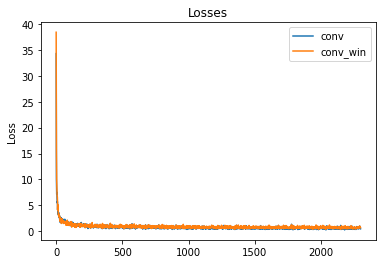

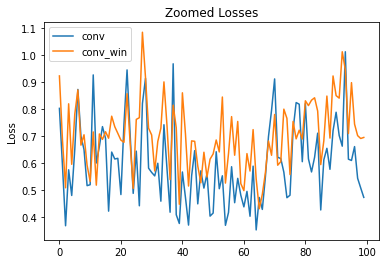

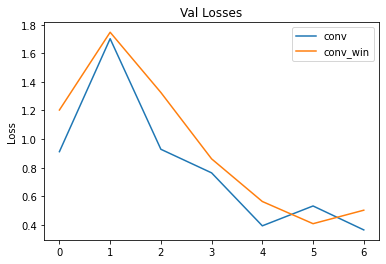

Accuracy:  [ 977. 1128. 1009. 1005.  975.  864.  939. 1018.  969. 1000.]
Accuracy_Win:  [ 978. 1120.  995. 1007.  957.  865.  946. 1020.  970. 1002.]
class_counter:  [ 980. 1135. 1032. 1010.  982.  892.  958. 1028.  974. 1009.]
Accuracy_percentage:  98.83999999999999
Accuracy_win_percentage:  98.6


<Figure size 432x288 with 0 Axes>

In [2]:
# -*- coding: utf-8 -*-

import os
import warnings


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
#from windowed_conv import Conv2d_window
import matplotlib.pyplot as plt
#-----------------------------------------------------------------------------------------------
"""import argparse

parser = argparse.ArgumentParser(description='CIFAR100 training with 7x7 window in all layers and weight decay')
parser.add_argument('--seed', default=None, type=int, help='rng seed')
parser.add_argument('--n_layers', default=6, type=int, help='total number of conv layers')
parser.add_argument('--save', type=str, default='/save_dir')

args = parser.parse_args()"""

# Fix seed
"""if args.seed is not None:
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    warnings.warn('You have chosen to seed training. '
                  'This will turn on the CUDNN deterministic setting, '
                  'which can slow down your training considerably! '
                  'You may see unexpected behavior when restarting '
                  'from checkpoints.')"""
#-----------------------------------------------------------------------------------------------
# Other useful definitions
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        shape=torch.prod(torch.tensor(x.shape[1:])).item()
        return x.reshape(-1,shape) # batchsize-by-rest

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

makedirs("/save_dir")

CELoss=nn.CrossEntropyLoss()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#-----------------------------------------------------------------------------------------------
# Define CIFAR100 dataloaders
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.ToTensor()])
transform_test=transforms.Compose([transforms.ToTensor()])
data_path='/path_to_cifar100'
batch_size=64
print("Batch_size: ", batch_size)

# Training data
cifar100_trainset=datasets.CIFAR100(root=data_path, train=True, transform=transform_train, download=True)
MNIST_trainset = datasets.MNIST(root=data_path, train=True, transform=transform_train, download=True)
#train_dl=torch.utils.data.DataLoader(cifar100_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
train_dl=torch.utils.data.DataLoader(MNIST_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Validation data
cifar100_testset=datasets.CIFAR100(root=data_path, train=False, transform=transform_test, download=True)
MNIST_testset=datasets.MNIST(root=data_path, train=False, transform=transform_test, download=True)
#test_dl=torch.utils.data.DataLoader(cifar100_testset, batch_size=batch_size, shuffle=False, num_workers=2)
test_dl=torch.utils.data.DataLoader(MNIST_testset, batch_size=batch_size, shuffle=False, num_workers=2)
#-----------------------------------------------------------------------------------------------
# Define the 2 models
#n_inp_ch=3 # CIFAR100
n_inp_ch=1 # MNIST
n_out_ch=128
n_out2_ch=256
n_classes=100 # CIFAR100
n_classes=10 # MNIST

# Define networks
n_layers=6

block=[]
block.append(torch.nn.Conv2d(n_inp_ch,n_out_ch,kernel_size=(7,7),stride=2,padding=(3,3),bias=False))
block.append(torch.nn.BatchNorm2d(n_out_ch))
block.append(torch.nn.ReLU())
block.append(torch.nn.Conv2d(n_out_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
block.append(torch.nn.BatchNorm2d(n_out2_ch))
block.append(torch.nn.ReLU())

block_win=[]
block_win.append(Conv2d_window(n_inp_ch,n_out_ch,kernel_size=(7,7),stride=2,padding=(3,3),bias=False))
block_win.append(torch.nn.BatchNorm2d(n_out_ch))
block_win.append(torch.nn.ReLU())
block_win.append(Conv2d_window(n_out_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
block_win.append(torch.nn.BatchNorm2d(n_out2_ch))
block_win.append(torch.nn.ReLU())

if n_layers>2:
    for i in range(n_layers-2):
        block.append(torch.nn.Conv2d(n_out2_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
        block.append(torch.nn.BatchNorm2d(n_out2_ch))
        block.append(torch.nn.ReLU())

        block_win.append(Conv2d_window(n_out2_ch,n_out2_ch,kernel_size=(7,7),padding=(3,3),bias=False))
        block_win.append(torch.nn.BatchNorm2d(n_out2_ch))
        block_win.append(torch.nn.ReLU())

model=torch.nn.Sequential(*block,torch.nn.AdaptiveAvgPool2d((1,1)),\
               Flatten(),torch.nn.Linear(n_out2_ch,n_classes)).to(device)

model_win=torch.nn.Sequential(*block_win,torch.nn.AdaptiveAvgPool2d((1,1)),\
               Flatten(),torch.nn.Linear(n_out2_ch,n_classes)).to(device)

if n_layers>13:
    warnings.warn("Networks deeper than 13 layers may not be ideal for small image sizes "+\
             +"(e.g. 32 x 32) and with the current width/pooling specifications")
#-----------------------------------------------------------------------------------------------
# Define optimizer
optim=torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9, weight_decay=0.001)
optim_win=torch.optim.SGD(model_win.parameters(),lr=0.01,momentum=0.9, weight_decay=0.001)
#-----------------------------------------------------------------------------------------------
# Training
loss_counter=0
log_loss=20 # track loss every 20 batches
n_epoch=50
#n_train_img=len(CIFAR10_trainset)
n_train_img=len(MNIST_trainset)

plot_loss=np.zeros(n_epoch*int(np.floor(np.ceil(n_train_img/batch_size)/log_loss)))
plot_loss_win=np.zeros(n_epoch*int(np.floor(np.ceil(n_train_img/batch_size)/log_loss)))

print("Totle number of Epochs:", n_epoch)

for i_epoch in range(n_epoch):
    print("Epoch: ", i_epoch)
    batch_counter=0
    running_loss=0
    running_loss_win=0

    # Learning rate decay
    if i_epoch==75 or i_epoch==120:
        for param_group in optim.param_groups:
            param_group['lr']=0.1*param_group['lr']
        for param_group in optim_win.param_groups:
            param_group['lr']=0.1*param_group['lr']

    for X,y in train_dl:
        batch_counter+=1
        # Train
        X=X.to(device)
        y=y.to(device)

        # Backprop model 1
        optim.zero_grad()
        pred=model(X)
        loss=CELoss(pred,y)
        loss.backward()
        optim.step()

        # Backprop model 2
        optim_win.zero_grad()
        pred_win=model_win(X)
        loss_win=CELoss(pred_win,y)
        loss_win.backward()
        optim_win.step()

        running_loss+=loss.item()
        running_loss_win+=loss_win.item()

        if batch_counter%log_loss==0:
            # print things
            print("Batch_Counter: ", batch_counter)
            print(np.argmax(pred[0,:].detach().cpu().numpy()),\
                  np.argmax(pred_win[0,:].detach().cpu().numpy()),\
                  y[0].detach().cpu().numpy())

            # update loss trace
            plot_loss[loss_counter]=running_loss
            plot_loss_win[loss_counter]=running_loss_win
            loss_counter+=1

            running_loss=0
            running_loss_win=0

# Plot losses
plt.figure(1)
plt.plot(plot_loss,label='conv')
plt.plot(plot_loss_win,label='conv_win')
plt.title('Losses')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join("/save_dir", 'loss_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')

# Plot losses zoomed in
plt.figure(2)
plt.plot(plot_loss[-100:],label='conv')
plt.plot(plot_loss_win[-100:],label='conv_win')
plt.title('Zoomed Losses')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join("/save_dir", 'loss_zoom_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')
#-----------------------------------------------------------------------------------------------
# Validation
accuracy=np.zeros(n_classes)
accuracy_win=np.zeros(n_classes)
class_counter=np.zeros(n_classes)

loss_counter=0
log_loss=20 # track loss every 20 batches
#n_test_img=len(cifar100_testset)
n_test_img=len(MNIST_testset)

plot_val_loss=np.zeros(int(np.floor(np.ceil(n_test_img/batch_size)/log_loss)))
plot_val_loss_win=np.zeros(int(np.floor(np.ceil(n_test_img/batch_size)/log_loss)))

print('Validating...')

batch_counter=0
running_loss=0
running_loss_win=0

with torch.no_grad():
    model.eval()
    model_win.eval()

    for X,y in test_dl:
        # Test
        batch_counter+=1
        X=X.to(device)

        pred=model(X)
        pred_win=model_win(X)

        loss=CELoss(pred,y.to(device))
        loss_win=CELoss(pred_win,y.to(device))
        running_loss+=loss.item()
        running_loss_win+=loss_win.item()

        # Get accuracy
        for j in range(int(y.shape[0])):
            i_class=y[j].detach().numpy().item()

            class_counter[i_class]+=1
            accuracy[i_class]+=(i_class==np.argmax(pred[j,:].detach().cpu().numpy()))
            accuracy_win[i_class]+=(i_class==np.argmax(pred_win[j,:].detach().cpu().numpy()))

        if batch_counter%log_loss==0:
            # print things
            print("Batch_Counter: ", batch_counter)

            # update loss trace
            plot_val_loss[loss_counter]=running_loss
            plot_val_loss_win[loss_counter]=running_loss_win
            loss_counter+=1

            running_loss=0
            running_loss_win=0

# Plot val loss
plt.figure(3)
plt.plot(plot_val_loss,label='conv')
plt.plot(plot_val_loss_win,label='conv_win')
plt.title('Val Losses')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig(os.path.join("/save_dir", 'val_loss_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')

# Print accuracies
print("Accuracy: ", accuracy)
print("Accuracy_Win: ", accuracy_win)
print("class_counter: ", class_counter)
print("Accuracy_percentage: ", accuracy.sum()/class_counter.sum()*100)
print("Accuracy_win_percentage: ", accuracy_win.sum()/class_counter.sum()*100)

# Save model + losses
torch.save({'state_dict': model.state_dict(), 'state_dict_win': model_win.state_dict(), 'training_loss': plot_loss, 'training_loss_win': plot_loss_win, 'val_loss': plot_val_loss, 'val_loDss_win': plot_val_loss_win, 'accuracy': accuracy, 'accuracy_win': accuracy_win, 'class_counter': class_counter}, os.path.join("/save_dir", 'model_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pth'))


#Only window the first layer with kb=3 on CIFAR-10

In [13]:
# -*- coding: utf-8 -*-
import math
import torch
from torch.nn.parameter import Parameter
import torch.nn.functional as F
import torch.nn.init as init
from torch.nn.modules.utils import _pair
from torch.nn.modules.module import Module
import numpy as np

def window_with_hamming(weight):
    N=weight.shape[-1]
    w=np.hamming(N)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting
def window_with_blackman(weight):
    N=weight.shape[-1]
    w=np.blackman(N)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting
def window_with_kaiser(weight):
    N=weight.shape[-1]
    w=np.kaiser(N,14)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting
def window_with_hanning(weight):
    N=weight.shape[-1]
    w=np.hanning(N)
    w_2d=torch.tensor(np.outer(w,w)).type(torch.cuda.FloatTensor)
    return weight*w_2d # broadcasting

class _ConvNd(Module):

    __constants__ = ['stride', 'padding', 'dilation', 'groups', 'bias',
                     'padding_mode', 'output_padding', 'in_channels',
                     'out_channels', 'kernel_size']

    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, dilation, transposed, output_padding,
                 groups, bias, padding_mode):
        super(_ConvNd, self).__init__()
        if in_channels % groups != 0:
            raise ValueError('in_channels must be divisible by groups')
        if out_channels % groups != 0:
            raise ValueError('out_channels must be divisible by groups')
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.transposed = transposed
        self.output_padding = output_padding
        self.groups = groups
        self.padding_mode = padding_mode
        if transposed:
            self.weight = Parameter(torch.Tensor(
                in_channels, out_channels // groups, *kernel_size))
        else:
            self.weight = Parameter(torch.Tensor(
                out_channels, in_channels // groups, *kernel_size))
        if bias:
            self.bias = Parameter(torch.Tensor(out_channels))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            init.uniform_(self.bias, -bound, bound)

    def extra_repr(self):
        s = ('{in_channels}, {out_channels}, kernel_size={kernel_size}'
             ', stride={stride}')
        if self.padding != (0,) * len(self.padding):
            s += ', padding={padding}'
        if self.dilation != (1,) * len(self.dilation):
            s += ', dilation={dilation}'
        if self.output_padding != (0,) * len(self.output_padding):
            s += ', output_padding={output_padding}'
        if self.groups != 1:
            s += ', groups={groups}'
        if self.bias is None:
            s += ', bias=False'
        return s.format(**self.__dict__)

    def __setstate__(self, state):
        super(_ConvNd, self).__setstate__(state)
        if not hasattr(self, 'padding_mode'):
            self.padding_mode = 'zeros'
#%%
class Conv2d_window(_ConvNd):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1,
                 bias=True, padding_mode='zeros'):
        kernel_size = _pair(kernel_size)
        stride = _pair(stride)
        padding = _pair(padding)
        dilation = _pair(dilation)
        super(Conv2d_window, self).__init__(
            in_channels, out_channels, kernel_size, stride, padding, dilation,
            False, _pair(0), groups, bias, padding_mode)

    def conv2d_forward(self, input, weight):
        weight=window_with_hamming(weight)
        if self.padding_mode == 'circular':
            expanded_padding = ((self.padding[1] + 1) // 2, self.padding[1] // 2,
                                (self.padding[0] + 1) // 2, self.padding[0] // 2)
            return F.conv2d(F.pad(input, expanded_padding, mode='circular'),
                            weight, self.bias, self.stride,
                            _pair(0), self.dilation, self.groups)
        return F.conv2d(input, weight, self.bias, self.stride,
                        self.padding, self.dilation, self.groups)

    def forward(self, input):
        return self.conv2d_forward(input, self.weight)


Batch_size:  64
Files already downloaded and verified
Files already downloaded and verified
Totle number of Epochs: 30
Epoch:  0
Batch_Counter:  20
5 5 0
Batch_Counter:  40
3 3 8
Batch_Counter:  60
8 8 0
Batch_Counter:  80
0 0 5
Batch_Counter:  100
6 6 6
Batch_Counter:  120
4 4 5
Batch_Counter:  140
4 4 4
Batch_Counter:  160
4 4 4
Batch_Counter:  180
4 4 2
Batch_Counter:  200
1 1 9
Batch_Counter:  220
8 8 8
Batch_Counter:  240
7 7 7
Batch_Counter:  260
6 7 2
Batch_Counter:  280
3 6 5
Batch_Counter:  300
3 5 7
Batch_Counter:  320
2 2 3
Batch_Counter:  340
6 6 9
Batch_Counter:  360
2 3 0
Batch_Counter:  380
5 5 5
Batch_Counter:  400
8 1 0
Batch_Counter:  420
3 3 7
Batch_Counter:  440
8 8 2
Batch_Counter:  460
6 7 5
Batch_Counter:  480
9 9 9
Batch_Counter:  500
4 4 5
Batch_Counter:  520
7 7 4
Batch_Counter:  540
2 2 2
Batch_Counter:  560
7 7 4
Batch_Counter:  580
6 6 6
Batch_Counter:  600
1 1 1
Batch_Counter:  620
8 1 8
Batch_Counter:  640
0 2 8
Batch_Counter:  660
7 7 5
Batch_Counter:  6

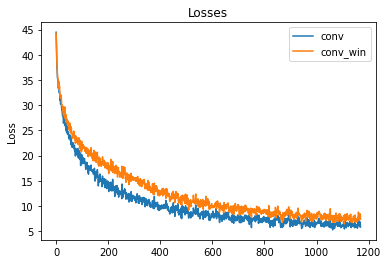

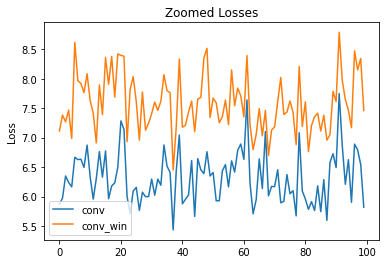

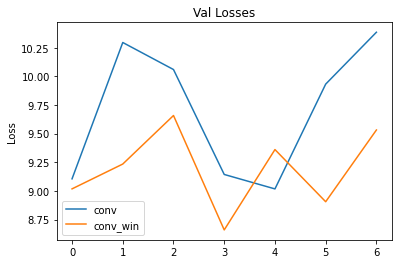

Accuracy:  [828. 975. 758. 701. 912. 619. 880. 926. 943. 818.]
Accuracy_Win:  [776. 965. 858. 591. 821. 823. 854. 897. 942. 890.]
class_counter:  [1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000. 1000.]
Accuracy_percentage:  83.6
Accuracy_win_percentage:  84.17


<Figure size 432x288 with 0 Axes>

In [14]:
# -*- coding: utf-8 -*-

import os
import warnings


import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
#from windowed_conv import Conv2d_window
import matplotlib.pyplot as plt
#-----------------------------------------------------------------------------------------------
"""import argparse

parser = argparse.ArgumentParser(description='CIFAR100 training with 7x7 window in all layers and weight decay')
parser.add_argument('--seed', default=None, type=int, help='rng seed')
parser.add_argument('--n_layers', default=6, type=int, help='total number of conv layers')
parser.add_argument('--save', type=str, default='/save_dir')

args = parser.parse_args()"""

# Fix seed
"""if args.seed is not None:
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    warnings.warn('You have chosen to seed training. '
                  'This will turn on the CUDNN deterministic setting, '
                  'which can slow down your training considerably! '
                  'You may see unexpected behavior when restarting '
                  'from checkpoints.')"""
#-----------------------------------------------------------------------------------------------
# Other useful definitions
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        shape=torch.prod(torch.tensor(x.shape[1:])).item()
        return x.reshape(-1,shape) # batchsize-by-rest

def makedirs(dirname):
    if not os.path.exists(dirname):
        os.makedirs(dirname)

makedirs("/save_dir")

CELoss=nn.CrossEntropyLoss()
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#-----------------------------------------------------------------------------------------------
# Define CIFAR100 dataloaders
transform_train = transforms.Compose([transforms.RandomHorizontalFlip(),
                                      transforms.RandomCrop(32, padding=4),
                                      transforms.ToTensor()])
transform_test=transforms.Compose([transforms.ToTensor()])
data_path='/path_to_cifar100'
batch_size=64
print("Batch_size: ", batch_size)

# Training data
cifar10_trainset=datasets.CIFAR10(root=data_path, train=True, transform=transform_train, download=True)
#MNIST_trainset = datasets.MNIST(root=data_path, train=True, transform=transform_train, download=True)
train_dl=torch.utils.data.DataLoader(cifar10_trainset, batch_size=batch_size, shuffle=True, num_workers=2)
#train_dl=torch.utils.data.DataLoader(MNIST_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Validation data
cifar10_testset=datasets.CIFAR10(root=data_path, train=False, transform=transform_test, download=True)
#MNIST_testset=datasets.MNIST(root=data_path, train=False, transform=transform_test, download=True)
test_dl=torch.utils.data.DataLoader(cifar10_testset, batch_size=batch_size, shuffle=False, num_workers=2)
#test_dl=torch.utils.data.DataLoader(MNIST_testset, batch_size=batch_size, shuffle=False, num_workers=2)
#-----------------------------------------------------------------------------------------------
# Define the 2 models
n_inp_ch=3 # CIFAR100
#n_inp_ch=1 # MNIST
n_out_ch=128
n_out2_ch=256
n_classes=10 # CIFAR100
#n_classes=10 # MNIST

# Define networks
n_layers=6

block=[]
block.append(torch.nn.Conv2d(n_inp_ch,n_out_ch,kernel_size=(3,3),stride=2,padding=(3,3),bias=False))
block.append(torch.nn.BatchNorm2d(n_out_ch))
block.append(torch.nn.ReLU())
block.append(torch.nn.Conv2d(n_out_ch,n_out2_ch,kernel_size=(3,3),padding=(3,3),bias=False))
block.append(torch.nn.BatchNorm2d(n_out2_ch))
block.append(torch.nn.ReLU())

block_win=[]
block_win.append(Conv2d_window(n_inp_ch,n_out_ch,kernel_size=(3,3),stride=2,padding=(3,3),bias=False))
block_win.append(torch.nn.BatchNorm2d(n_out_ch))
block_win.append(torch.nn.ReLU())
block_win.append(torch.nn.Conv2d(n_out_ch,n_out2_ch,kernel_size=(3,3),padding=(3,3),bias=False))
block_win.append(torch.nn.BatchNorm2d(n_out2_ch))
block_win.append(torch.nn.ReLU())

if n_layers>2:
    for i in range(n_layers-2):
        block.append(torch.nn.Conv2d(n_out2_ch,n_out2_ch,kernel_size=(3,3),padding=(3,3),bias=False))
        block.append(torch.nn.BatchNorm2d(n_out2_ch))
        block.append(torch.nn.ReLU())

        block_win.append(torch.nn.Conv2d(n_out2_ch,n_out2_ch,kernel_size=(3,3),padding=(3,3),bias=False))
        block_win.append(torch.nn.BatchNorm2d(n_out2_ch))
        block_win.append(torch.nn.ReLU())

model=torch.nn.Sequential(*block,torch.nn.AdaptiveAvgPool2d((1,1)),\
               Flatten(),torch.nn.Linear(n_out2_ch,n_classes)).to(device)

model_win=torch.nn.Sequential(*block_win,torch.nn.AdaptiveAvgPool2d((1,1)),\
               Flatten(),torch.nn.Linear(n_out2_ch,n_classes)).to(device)

if n_layers>13:
    warnings.warn("Networks deeper than 13 layers may not be ideal for small image sizes "+\
             +"(e.g. 32 x 32) and with the current width/pooling specifications")
#-----------------------------------------------------------------------------------------------
# Define optimizer
optim=torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9, weight_decay=0.001)
optim_win=torch.optim.SGD(model_win.parameters(),lr=0.01,momentum=0.9, weight_decay=0.001)
#-----------------------------------------------------------------------------------------------
# Training
loss_counter=0
log_loss=20 # track loss every 20 batches
n_epoch=30
n_train_img=len(cifar10_trainset)
#n_train_img=len(MNIST_trainset)

plot_loss=np.zeros(n_epoch*int(np.floor(np.ceil(n_train_img/batch_size)/log_loss)))
plot_loss_win=np.zeros(n_epoch*int(np.floor(np.ceil(n_train_img/batch_size)/log_loss)))

print("Totle number of Epochs:", n_epoch)

for i_epoch in range(n_epoch):
    print("Epoch: ", i_epoch)
    batch_counter=0
    running_loss=0
    running_loss_win=0

    # Learning rate decay
    if i_epoch==75 or i_epoch==120:
        for param_group in optim.param_groups:
            param_group['lr']=0.1*param_group['lr']
        for param_group in optim_win.param_groups:
            param_group['lr']=0.1*param_group['lr']

    for X,y in train_dl:
        batch_counter+=1
        # Train
        X=X.to(device)
        y=y.to(device)

        # Backprop model 1
        optim.zero_grad()
        pred=model(X)
        loss=CELoss(pred,y)
        loss.backward()
        optim.step()

        # Backprop model 2
        optim_win.zero_grad()
        pred_win=model_win(X)
        loss_win=CELoss(pred_win,y)
        loss_win.backward()
        optim_win.step()

        running_loss+=loss.item()
        running_loss_win+=loss_win.item()

        if batch_counter%log_loss==0:
            # print things
            print("Batch_Counter: ", batch_counter)
            print(np.argmax(pred[0,:].detach().cpu().numpy()),\
                  np.argmax(pred_win[0,:].detach().cpu().numpy()),\
                  y[0].detach().cpu().numpy())

            # update loss trace
            plot_loss[loss_counter]=running_loss
            plot_loss_win[loss_counter]=running_loss_win
            loss_counter+=1

            running_loss=0
            running_loss_win=0

# Plot losses
plt.figure(1)
plt.plot(plot_loss,label='conv')
plt.plot(plot_loss_win,label='conv_win')
plt.title('Losses')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join("/save_dir", 'loss_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')

# Plot losses zoomed in
plt.figure(2)
plt.plot(plot_loss[-100:],label='conv')
plt.plot(plot_loss_win[-100:],label='conv_win')
plt.title('Zoomed Losses')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join("/save_dir", 'loss_zoom_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')
#-----------------------------------------------------------------------------------------------
# Validation
accuracy=np.zeros(n_classes)
accuracy_win=np.zeros(n_classes)
class_counter=np.zeros(n_classes)

loss_counter=0
log_loss=20 # track loss every 20 batches
n_test_img=len(cifar10_testset)
#n_test_img=len(MNIST_testset)

plot_val_loss=np.zeros(int(np.floor(np.ceil(n_test_img/batch_size)/log_loss)))
plot_val_loss_win=np.zeros(int(np.floor(np.ceil(n_test_img/batch_size)/log_loss)))

print('Validating...')

batch_counter=0
running_loss=0
running_loss_win=0

with torch.no_grad():
    model.eval()
    model_win.eval()

    for X,y in test_dl:
        # Test
        batch_counter+=1
        X=X.to(device)

        pred=model(X)
        pred_win=model_win(X)

        loss=CELoss(pred,y.to(device))
        loss_win=CELoss(pred_win,y.to(device))
        running_loss+=loss.item()
        running_loss_win+=loss_win.item()

        # Get accuracy
        for j in range(int(y.shape[0])):
            i_class=y[j].detach().numpy().item()

            class_counter[i_class]+=1
            accuracy[i_class]+=(i_class==np.argmax(pred[j,:].detach().cpu().numpy()))
            accuracy_win[i_class]+=(i_class==np.argmax(pred_win[j,:].detach().cpu().numpy()))

        if batch_counter%log_loss==0:
            # print things
            print("Batch_Counter: ", batch_counter)

            # update loss trace
            plot_val_loss[loss_counter]=running_loss
            plot_val_loss_win[loss_counter]=running_loss_win
            loss_counter+=1

            running_loss=0
            running_loss_win=0

# Plot val loss
plt.figure(3)
plt.plot(plot_val_loss,label='conv')
plt.plot(plot_val_loss_win,label='conv_win')
plt.title('Val Losses')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.savefig(os.path.join("/save_dir", 'val_loss_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pdf'), bbox_inches='tight')

# Print accuracies
print("Accuracy: ", accuracy)
print("Accuracy_Win: ", accuracy_win)
print("class_counter: ", class_counter)
print("Accuracy_percentage: ", accuracy.sum()/class_counter.sum()*100)
print("Accuracy_win_percentage: ", accuracy_win.sum()/class_counter.sum()*100)

# Save model + losses
torch.save({'state_dict': model.state_dict(), 'state_dict_win': model_win.state_dict(), 'training_loss': plot_loss, 'training_loss_win': plot_loss_win, 'val_loss': plot_val_loss, 'val_loDss_win': plot_val_loss_win, 'accuracy': accuracy, 'accuracy_win': accuracy_win, 'class_counter': class_counter}, os.path.join("/save_dir", 'model_cifar100_all_win_wd_'+str(n_layers)+'_layers_'+str(None)+'.pth'))
